Cosetes

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from sklearn.preprocessing import MinMaxScaler


file_path = '../accions.csv'
file_path2 = '../tramits.csv'
# Load the CSV file
df = pd.read_csv(file_path)

# Sample 10000 random rows from the dataframe
df = df.sample(n=4000, random_state=42)
#df = df[df['Usuari'].notnull()]
#df = df[df['Accio'].notnull()]
df_tramits = pd.read_csv(file_path2)

# Merge the two dataframes on 'Tramit' and 'id'
df = pd.merge(df, df_tramits, left_on='Tramit', right_on='Id', how='inner')

df['Data'] = pd.to_datetime(df['Data'])

df['Año'] = df['Data'].dt.year
df['Mes'] = df['Data'].dt.month
df['Hora'] = df['Data'].dt.hour
df['Día de la semana'] = df['Data'].dt.weekday  # 0 = Lunes, 6 = Domingo

# Estandarizar las nuevas columnas
scaler = MinMaxScaler()
df[['Año', 'Mes', 'Hora', 'Día de la semana']] = scaler.fit_transform(df[['Año', 'Mes', 'Hora', 'Día de la semana']])

df['Representat'] = df['Representat'].apply(lambda x: 1 if pd.notnull(x) else 0)
df['Usuari'] = df['Usuari'].apply(lambda x: 1 if pd.notnull(x) else 0)

df = df.drop(columns=['Id', 'Sessio','Tramit','Data'])
# Normalize the titles by converting them to lowercase

In [4]:
stopwords_catalan = [
    'com', 'de', 'a', 'per', 'i', 'amb', 'en', 'els', 'les', 'un', 'una', 'dels', 'del', 'en', 'els', 
    'les', 'aquest', 'aquesta', 'aquell', 'aquella', 'aquells', 'aquelles', 'els', 'les', 'meu', 'meva', 
    'meus', 'meves', 'tú', 'tu', 'teu', 'teva', 'teus', 'teves', 'seu', 'seva', 'seus', 'seves', 'nostre', 
    'nostra', 'nostres', 'nostres', 'vostre', 'vostra', 'vostres', 'vostres', 'jo', 'ell', 'ella', 'nosaltres', 
    'vosaltres', 'ells', 'elles', 'això', 'aquesta', 'alguns', 'alguna', 'algunes', 'alguns', 'també', 'tot', 
    'tots', 'totes', 'aquí', 'allà', 'més', 'menys', 'tant', 'tan', 'molt', 'poc', 'igual', 'és', 'era', 
    'ha', 'va', 'ser', 'si', 'no', 'quan', 'on', 'perquè', 'perquè', 'doncs', 'però', 'potser', 'encara', 
    'ja', 'ni', 'això', 'amb', 'com', 'encara', 'tot', 'aquest', 'aquesta', 'més', 'ser', 'més', 'el','la', 'fer', 'al', 'sol'
]

vectorizer = TfidfVectorizer(stop_words=stopwords_catalan)
df['Titol'] = df['Titol'].str.lower()
df['Titol'] = df['Titol'].str.replace(r'\bpública\b', 'públic', regex=True)
df['Titol'] = df['Titol'].str.replace(r'\bmunicipals\b', 'municipal', regex=True)
X = vectorizer.fit_transform(df['Titol'])
df['Titol'] = df['Titol'].str.replace('licitud', 'solicitud')
df_embeddings = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

In [5]:
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler
sentences = df['Titol'].apply(lambda x: x.split())
model = Word2Vec(sentences, vector_size=30, window=5, min_count=1, workers=4)

def get_sentence_vector(sentence):
    words = sentence.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.vector_size)

df_embeddings = pd.DataFrame(df['Titol'].apply(get_sentence_vector).to_list())

scaler = MinMaxScaler()

# Estandarizar las representaciones vectoriales
df_embeddings_standardized = scaler.fit_transform(df_embeddings)

# Convertir el resultado de nuevo a un DataFrame si lo necesitas
df_embeddings = pd.DataFrame(df_embeddings_standardized)
# Imprimir las primeras filas del DataFrame con las representaciones vectoriales
df_embeddings.columns = [str(i) for i in range(df_embeddings.shape[1])]
print(df_embeddings.head())

          0         1         2         3         4         5         6  \
0  0.506248  0.495372  0.619179  0.636722  0.226889  0.508098  0.450554   
1  0.679062  0.242858  0.679134  0.705395  0.302309  0.550263  0.561818   
2  0.250708  0.495026  0.812125  0.484520  0.140120  0.319430  0.352040   
3  0.623787  0.604483  0.732583  0.871608  0.089243  0.023603  0.240328   
4  0.703076  0.000000  0.756629  0.711713  0.478023  0.587624  0.805048   

          7         8         9  ...        20        21        22        23  \
0  0.565946  0.510946  0.475461  ...  0.668283  0.679855  0.473227  0.555391   
1  0.646186  0.407609  0.601014  ...  0.721918  0.576259  0.399567  0.635527   
2  0.417465  0.250136  0.306032  ...  0.594572  0.712597  0.325217  0.395190   
3  0.542525  0.567412  0.375007  ...  0.786072  0.899376  0.716396  0.623851   
4  0.791853  0.475110  0.726022  ...  0.912467  0.580691  0.534619  0.780046   

         24        25        26        27        28        29  
0  0

In [6]:
dfnou = df.drop(columns=['Titol'])
dfnou = pd.concat([dfnou, df_embeddings], axis=1)
dfnou['Vigent'] = dfnou['Vigent'].apply(lambda x: 1 if x else 0)

#df['Accio'] = df['Accio'].apply(lambda x: 0 if x == 'AFIT' else 0.5 if x == 'AFST' else 1)

print(dfnou)

     Accio  Usuari  Representat  Vigent    Año       Mes      Hora  \
0     AFST       0            0       1  0.875  0.000000  0.652174   
1     AFST       0            0       1  1.000  0.454545  0.086957   
2     AFST       1            0       1  0.875  0.454545  0.956522   
3     AFIT       0            0       1  0.125  0.181818  0.478261   
4     AFIT       0            0       1  0.625  0.454545  0.347826   
...    ...     ...          ...     ...    ...       ...       ...   
3995  PFST       1            0       1  0.750  0.181818  0.826087   
3996  AFIT       0            0       1  0.625  0.818182  0.391304   
3997  AFST       1            0       1  0.750  0.454545  0.739130   
3998  AFIT       0            0       1  0.625  0.454545  0.608696   
3999  AFIT       1            0       1  0.625  0.363636  0.521739   

      Día de la semana         0         1  ...        20        21        22  \
0             0.166667  0.506248  0.495372  ...  0.668283  0.679855  0.473227 

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

le = LabelEncoder()
y = le.fit_transform(dfnou['Accio'])
print(y)
X = dfnou.drop(['Accio', 'Usuari','Vigent'], axis=1)

# Crear el objeto RandomUnderSampler
#undersample = RandomUnderSampler(sampling_strategy='auto', random_state=42)
#X_resampled, y_resampled = undersample.fit_resample(X, y)



print(pd.Series(y).value_counts())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

first_row_X_test = X_test.iloc[0]
#first_row_X_test.to_csv('first_row_X_test.csv', index=False)
#print(first_row_X_test)
# Convert the first row of X_test to JSON
first_row_json = first_row_X_test.to_json()
print(first_row_json)


smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(pd.Series(y_train_resampled).value_counts())
# Split antes de balancear para evitar data leakage

[1 1 1 ... 1 0 0]
0    2918
1     928
2     154
Name: count, dtype: int64
{"Representat":0.0,"A\u00f1o":0.875,"Mes":1.0,"Hora":0.7391304348,"D\u00eda de la semana":0.1666666667,"0":0.4932106435,"1":0.5902218819,"2":0.4109863639,"3":0.5962449312,"4":0.2412878275,"5":0.6487070322,"6":0.404060632,"7":0.484646678,"8":0.6702332497,"9":0.4574142098,"10":0.3169125319,"11":0.6209185719,"12":0.3031664193,"13":0.7277643681,"14":0.3295059204,"15":0.692181766,"16":0.3870207965,"17":0.3631242514,"18":0.6718112826,"19":0.3400531113,"20":0.6434921026,"21":0.6926678419,"22":0.3953168094,"23":0.4204028845,"24":0.3651322722,"25":0.2733063102,"26":0.3055613041,"27":0.3803853095,"28":0.5090682507,"29":0.60477072}
0    2325
1    2325
2    2325
Name: count, dtype: int64


In [8]:
"""from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns

X_train_resampled2 = np.array(X_train_resampled)
X_train_resampled2 = X_train_resampled2.reshape((X_train_resampled2.shape[0], 1, X_train_resampled2.shape[1]))
y_train_resampled2 = to_categorical(np.array(y_train_resampled))

from tensorflow.keras import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout # type: ignore


# Crear el modelo
model = Sequential()

# Capa LSTM con 50 neuronas
model.add(LSTM(50, activation='relu', input_shape=(1, X_train_resampled.shape[1])))

# Opcional: Dropout para evitar overfitting
model.add(Dropout(0.2))

# Capa densa de salida (ajusta según el número de clases o regresión)
if len(np.unique(y_train_resampled)) > 2:  # Clasificación multiclase
    model.add(Dense(len(np.unique(y_train_resampled)), activation='softmax'))
    loss_function = 'categorical_crossentropy'
else:  # Clasificación binaria
    model.add(Dense(1, activation='sigmoid'))
    loss_function = 'binary_crossentropy'

# Compilar el modelo
model.compile(optimizer='adam', loss=loss_function, metrics=['accuracy'])

history = model.fit(X_train_resampled2, y_train_resampled2, epochs=50, batch_size=32, validation_split=0.2)

# Dar forma a X_test (igual que para X_train_resampled)
X_test = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))
y_test_categorical = to_categorical(y_test)

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test_categorical)
print(f"Pérdida: {loss}, Precisión: {accuracy}")

X_test = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Pérdida: {loss}, Precisión: {accuracy}")"""




'from tensorflow.keras.utils import to_categorical\nfrom sklearn.metrics import confusion_matrix\nimport seaborn as sns\n\nX_train_resampled2 = np.array(X_train_resampled)\nX_train_resampled2 = X_train_resampled2.reshape((X_train_resampled2.shape[0], 1, X_train_resampled2.shape[1]))\ny_train_resampled2 = to_categorical(np.array(y_train_resampled))\n\nfrom tensorflow.keras import Sequential # type: ignore\nfrom tensorflow.keras.layers import LSTM, Dense, Dropout # type: ignore\n\n\n# Crear el modelo\nmodel = Sequential()\n\n# Capa LSTM con 50 neuronas\nmodel.add(LSTM(50, activation=\'relu\', input_shape=(1, X_train_resampled.shape[1])))\n\n# Opcional: Dropout para evitar overfitting\nmodel.add(Dropout(0.2))\n\n# Capa densa de salida (ajusta según el número de clases o regresión)\nif len(np.unique(y_train_resampled)) > 2:  # Clasificación multiclase\n    model.add(Dense(len(np.unique(y_train_resampled)), activation=\'softmax\'))\n    loss_function = \'categorical_crossentropy\'\nelse:  #

In [9]:
"""from sklearn.metrics import classification_report, confusion_matrix
# Predecir las etiquetas del conjunto de prueba
y_pred_lstm = model.predict(X_test)
y_pred_lstm_classes = np.argmax(y_pred_lstm, axis=1)

# Calcular la matriz de confusión
cm_lstm = confusion_matrix(y_test, y_pred_lstm_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - LSTM')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.show()"""

"from sklearn.metrics import classification_report, confusion_matrix\n# Predecir las etiquetas del conjunto de prueba\ny_pred_lstm = model.predict(X_test)\ny_pred_lstm_classes = np.argmax(y_pred_lstm, axis=1)\n\n# Calcular la matriz de confusión\ncm_lstm = confusion_matrix(y_test, y_pred_lstm_classes)\n\n# Visualizar la matriz de confusión\nplt.figure(figsize=(10, 8))\nsns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues')\nplt.title('Matriz de Confusión - LSTM')\nplt.ylabel('Valor Real')\nplt.xlabel('Predicción')\nplt.show()"

In [10]:
"""from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'num_leaves': [15, 31, 63],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500],
    'max_depth': [-1, 5, 10],
    'min_child_samples': [10, 20, 50],
    'subsample': [0.6, 0.8, 1.0]
}

model = lgb.LGBMClassifier(objective='multiclass', num_class=3, random_state=42, n_jobs=-1)

# Búsqueda aleatoria
search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=50,
    scoring='accuracy',  # Cambia por la métrica que desees optimizar
    cv=3,  # Validación cruzada
    verbose=1,
    random_state=42
)

search.fit(X_train_resampled, y_train_resampled)
best_model = search.best_estimator_

# Entrena el mejor modelo encontrado
best_model.fit(X_train_resampled, y_train_resampled)

model.fit(
    X_train_resampled, 
    y_train_resampled,
    eval_set=[(X_test, y_test)],  # Establece el conjunto de validación
    eval_metric='multi_logloss',  # Métrica para evalu                   # Muestra el progreso
)


y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Imprimir reporte de clasificación
print("\nInforme de Clasificación:")
print(classification_report(y_test, y_pred))
#model.fit(X_train, y_train)"""

'from sklearn.metrics import classification_report, confusion_matrix\nfrom sklearn.model_selection import RandomizedSearchCV\n\nparam_grid = {\n    \'num_leaves\': [15, 31, 63],\n    \'learning_rate\': [0.01, 0.05, 0.1, 0.2],\n    \'n_estimators\': [100, 200, 500],\n    \'max_depth\': [-1, 5, 10],\n    \'min_child_samples\': [10, 20, 50],\n    \'subsample\': [0.6, 0.8, 1.0]\n}\n\nmodel = lgb.LGBMClassifier(objective=\'multiclass\', num_class=3, random_state=42, n_jobs=-1)\n\n# Búsqueda aleatoria\nsearch = RandomizedSearchCV(\n    estimator=model,\n    param_distributions=param_grid,\n    n_iter=50,\n    scoring=\'accuracy\',  # Cambia por la métrica que desees optimizar\n    cv=3,  # Validación cruzada\n    verbose=1,\n    random_state=42\n)\n\nsearch.fit(X_train_resampled, y_train_resampled)\nbest_model = search.best_estimator_\n\n# Entrena el mejor modelo encontrado\nbest_model.fit(X_train_resampled, y_train_resampled)\n\nmodel.fit(\n    X_train_resampled, \n    y_train_resampled,\n 

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV


model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=3,
    random_state=42,
    n_jobs=-1,
    num_leaves=63,
    learning_rate=0.2,
    n_estimators=500,
    min_child_samples=10,
    max_depth=-1,
    subsample=1.0
)

#{'subsample': 1.0, 'num_leaves': 63, 'n_estimators': 500, 'min_child_samples': 10, 'max_depth': -1, 'learning_rate': 0.2}

model.fit(
    X_train_resampled, 
    y_train_resampled,
    eval_set=[(X_test, y_test)],  # Establece el conjunto de validación
    eval_metric='multi_logloss',  # Métrica para evalu                   # Muestra el progreso
)


y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Imprimir reporte de clasificación
print("\nInforme de Clasificación:")
print(classification_report(y_test, y_pred))
#model.fit(X_train, y_train)
# 
"""print("Mejor puntaje (validación):")
print(search.best_score_)
{'subsample': 1.0, 'num_leaves': 63, 'n_estimators': 500, 'min_child_samples': 10, 'max_depth': -1, 'learning_rate': 0.2}
print("Mejor puntaje (validación):")
print(search.best_params_)"""


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8606
[LightGBM] [Info] Number of data points in the train set: 6975, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

'print("Mejor puntaje (validación):")\nprint(search.best_score_)\n{\'subsample\': 1.0, \'num_leaves\': 63, \'n_estimators\': 500, \'min_child_samples\': 10, \'max_depth\': -1, \'learning_rate\': 0.2}\nprint("Mejor puntaje (validación):")\nprint(search.best_params_)'

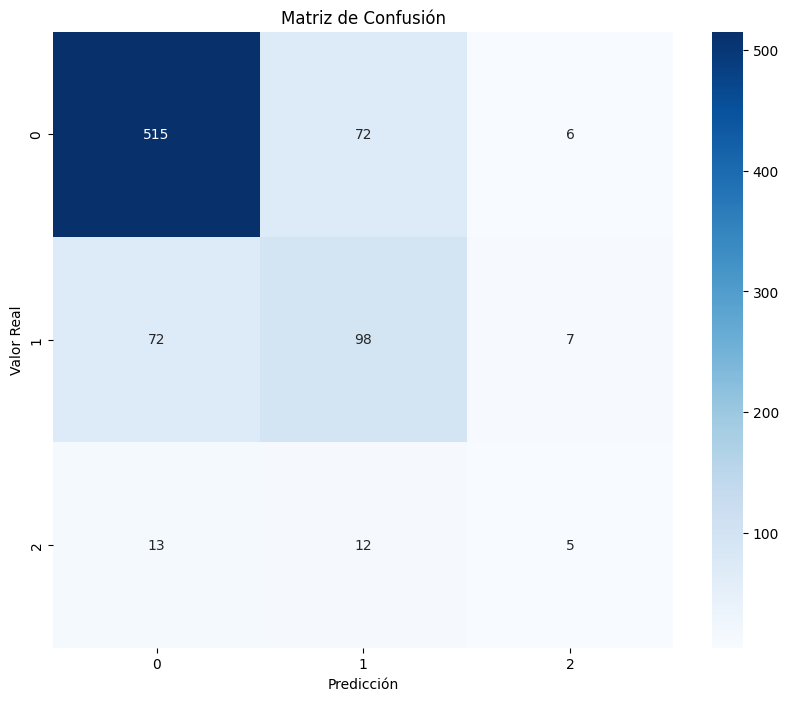

In [12]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.show()

In [13]:
import joblib

#joblib.dump(model, 'mejor_modelo_lgb.pkl')
print("Modelo guardado como 'mejor_modelo_lgb.pkl'")




Modelo guardado como 'mejor_modelo_lgb.pkl'


In [15]:
y_pred = model.predict(X_test)
print(y_pred)

[0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1
 1 0 0 1 0 0 1 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 2 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 2 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0
 0 2 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 1 0 0 0 2 1 2 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1 0 2 0 0 0
 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 1 0 1 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 1 2 1 1 1 0 2 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 